#  On the relationship between La Niña and droughts in East Africa

"Every five or so years, [...] a La Niña weather cycle brings devastating drought and hunger to East Africa"
(see ["Ethiopia, Somalia and Kenya face devastating drought"](https://www.nature.com/articles/d41586-020-02698-3), Nature, 15 October 2020).  

This notebook examines the relationship between La Niña and droughts in the region, to see if the warnings in the *Nature* article can be corroborated very simply with data available in [Gro](https://app.gro-intelligence.com).  

The data used here can be inspected in [this display on Gro](https://app.gro-intelligence.com/displays/3dW3V6zdD).

In [1]:
import os
from groclient import client

client = client.GroClient('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])

## Drought

There are many data series related to drought. Here we use the [Gro Drought Index (GDI)](https://gro-intelligence.com/gro-models/gro-drought-index), which is available at the district and province level, daily and weekly.  For simplicity, let us take the weekly GDI series at the province level.

In [2]:
for country in ['Ethiopia', 'Kenya', 'Somalia']:
    country_id = client.search_for_entity('regions', country)
    for region in client.get_descendant_regions(country_id, 4):   
        for series in client.get_data_series(item_id=17388, metric_id=15852252, frequency_id=2, region_id=region['id']):
            client.add_single_data_series(series)

## El Niño & La Niña 

The [El Niño-Southern Oscillation (ENSO)](https://app.gro-intelligence.com/dictionary/sources/124) data series captures the El Niño/La Niña cycle, which is global.

In [3]:
client.add_data_series(item = "Multivariate ENSO Index", metric="El Niño Southern Oscillation Index")

{'metric_id': 15851977,
 'metric_name': 'El Niño Southern Oscillation Index',
 'item_id': 13495,
 'item_name': 'Multivariate ENSO Index',
 'region_id': 0,
 'region_name': 'World',
 'partner_region_id': 0,
 'partner_region_name': 'World',
 'frequency_id': 6,
 'frequency_name': 'monthly',
 'source_id': 124,
 'source_name': 'NOAA MEI v2',
 'start_date': '1979-01-01T00:00:00.000Z',
 'end_date': '2020-09-30T00:00:00.000Z',
 'data_count_estimate': 509}

## Data prep

In [4]:
import pandas as pd

df = client.get_df()
print(df.shape)

(43441, 13)


For a simple approximation, we convert the weekly data to monthly and average each series across the whole region. Note the temporal aggregation is just an aggregation, but the spatial aspect is a bit imprecise as it gives equal weight to all provinces instead of weighting them by area.

In [5]:
all_monthly_series = []

for group, series_df in df.groupby(['item_id', 'metric_id']):
    mmdf = series_df.set_index('end_date').groupby(pd.Grouper(freq="M")).mean()
    label = client.lookup('metrics', group[1])['name']
    all_monthly_series.append((label, mmdf))
    print(label, mmdf.shape)

El Niño Southern Oscillation Index (501, 10)
Drought Severity and Coverage Index (131, 10)


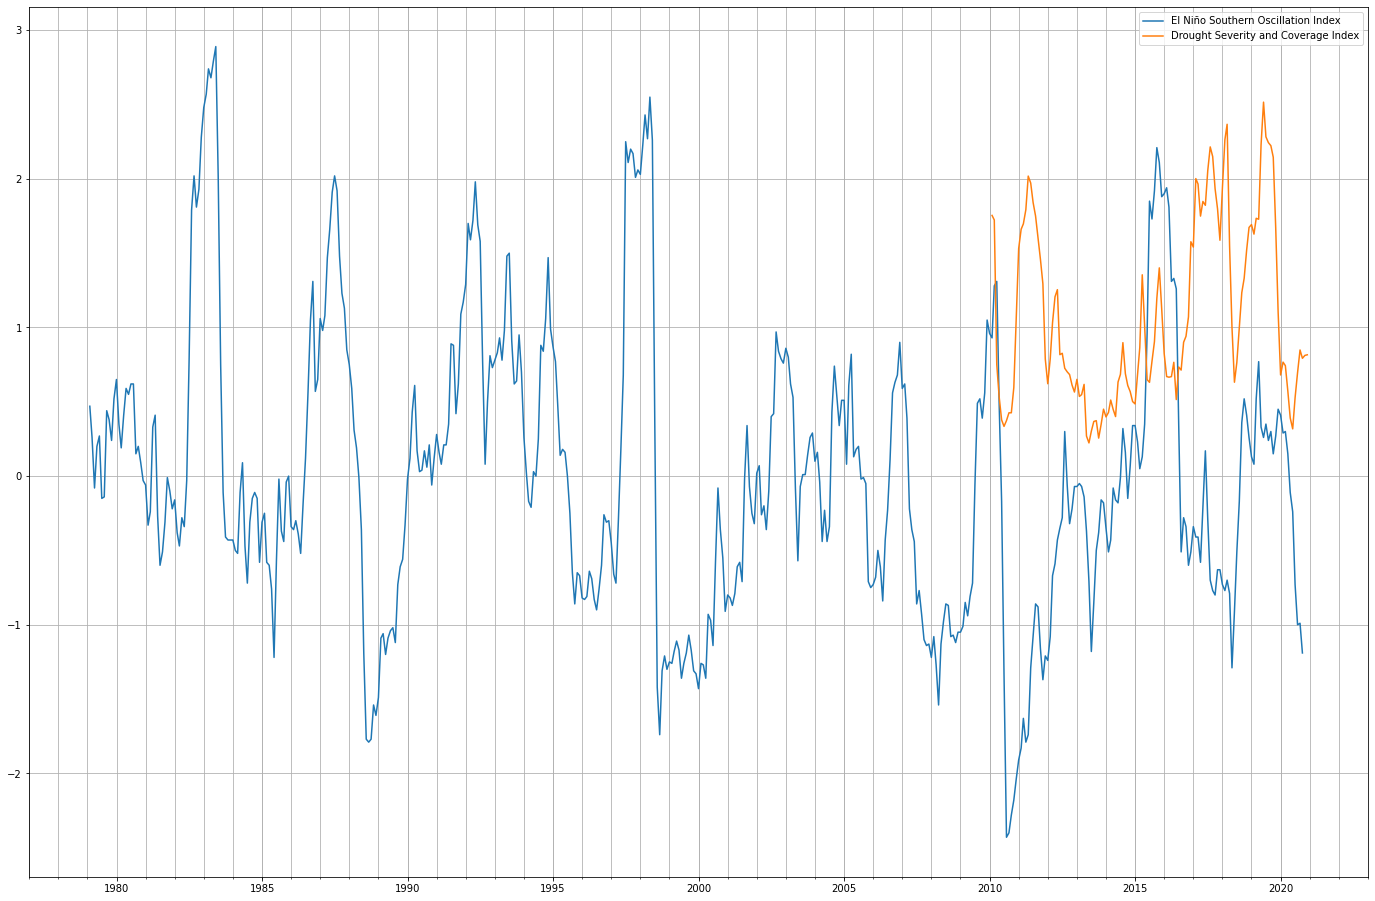

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

fig, axes = plt.subplots(1, 1, figsize=(24,16))

for label,s in all_monthly_series:
    plt.plot(s.index.to_pydatetime(), s['value'], label="{}".format(label))
    
plt.legend(loc='upper right')
plt.grid(b=True, which='both')
axes.xaxis.set_minor_locator(AutoMinorLocator(5))

## Analysis
Let's examine the correlation between ENSO and the Gro Drought Index.

<AxesSubplot:xlabel='El Niño Southern Oscillation Index', ylabel='Drought Severity and Coverage Index'>

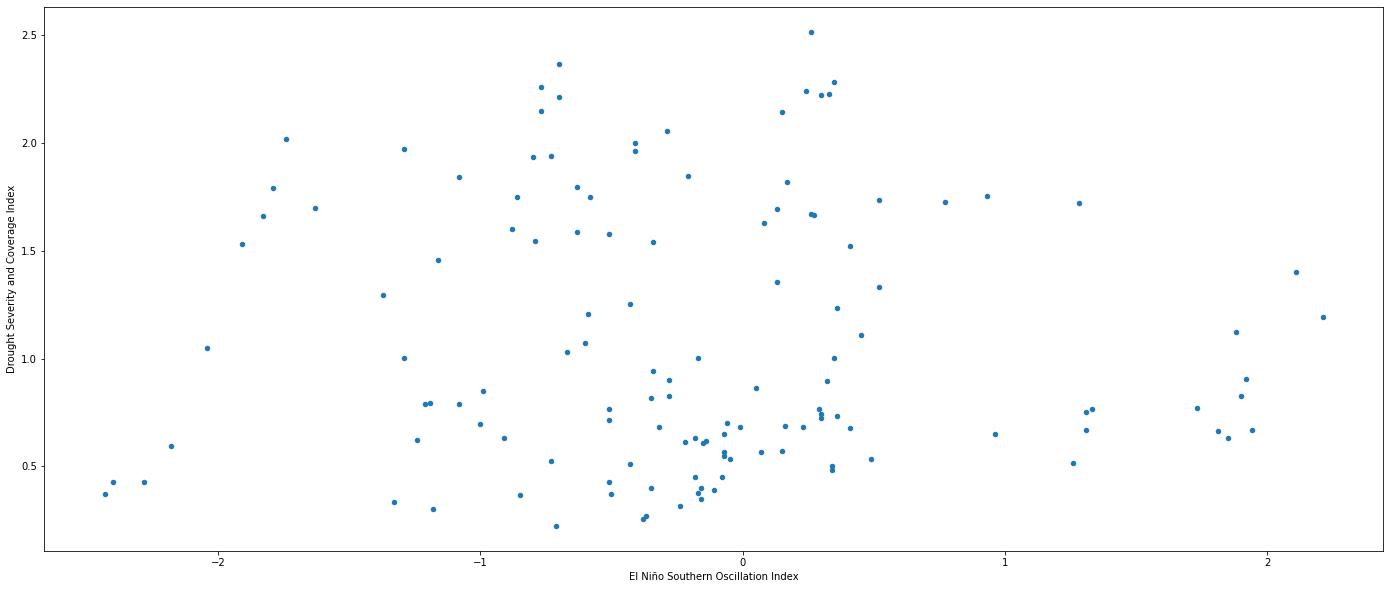

In [7]:
sdf = None

for g, s in all_monthly_series:
    d = s.rename(mapper={'value': g}, axis='columns')[[g]]
    if sdf is None:
        sdf = d
    else:
        sdf = sdf.join(d, on=['end_date'], how='inner')

fig, axes = plt.subplots(1,1, figsize=(24,10))
sdf.plot.scatter(x='El Niño Southern Oscillation Index', y='Drought Severity and Coverage Index', ax=axes)

In [8]:
sdf.corr(method='pearson')

,El Niño Southern Oscillation Index,Drought Severity and Coverage Index
El Niño Southern Oscillation Index,1.000000,-0.042297
Drought Severity and Coverage Index,-0.042297,1.000000


Negative ENSO corresponds to La Niña episodes. So while there's some correlation with droughts, it appears to be very weak -- about 4%. However, we can improve our analysis in a couple of ways. 

First, since the claimed effect is of La Niña, let's ignore El Niño, and consider only the moderate to strong La Nina conditions, where ENSO values  < -1.0.

In [9]:
enso = all_monthly_series[0][1].copy()
la_nina = enso[enso['value'] < -1.0]

Second, La Niña anticipates the drought by a few months, so let us shift ENSO by +6 months.

In [10]:
la_nina.index = la_nina.index + pd.offsets.MonthEnd(6)

<AxesSubplot:xlabel='El Niño Southern Oscillation Index', ylabel='Drought Severity and Coverage Index'>

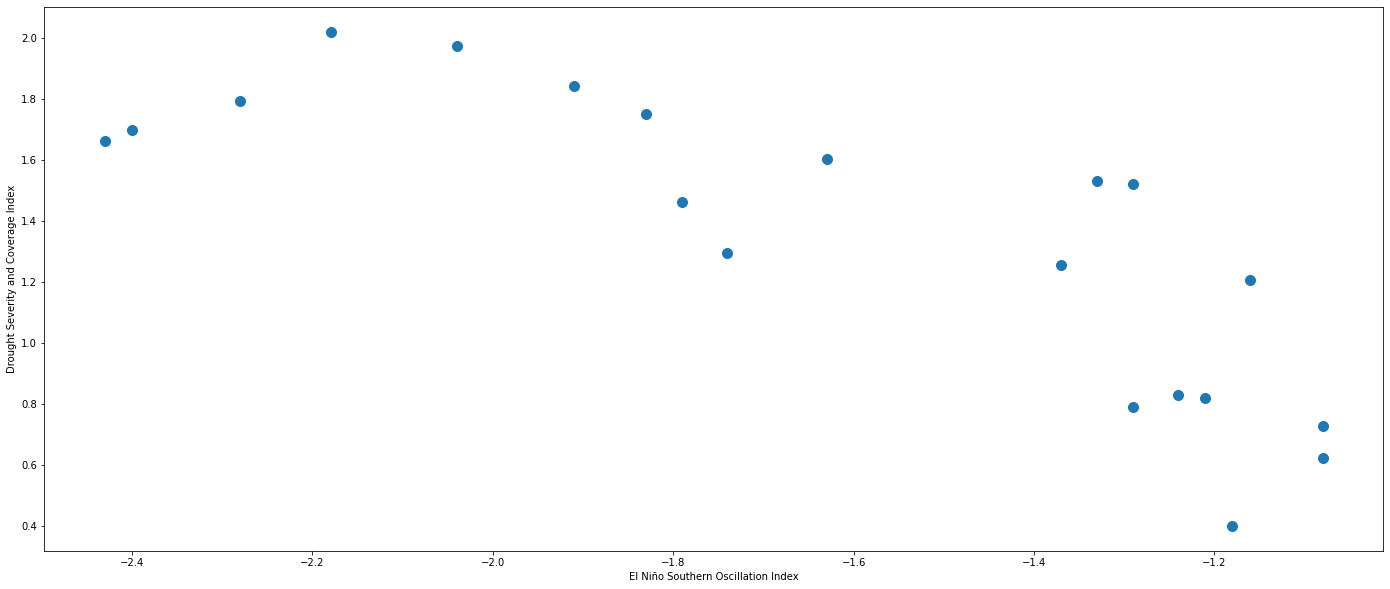

In [11]:
shifted_monthly_series = [(all_monthly_series[0][0], la_nina), all_monthly_series[1]]

ssdf = None

for g, s in shifted_monthly_series:
    d = s.rename(mapper={'value': g}, axis='columns')[[g]]
    if ssdf is None:
        ssdf = d
    else:
        ssdf = ssdf.join(d, on=['end_date'], how='inner')

fig, axes = plt.subplots(1,1, figsize=(24,10))
ssdf.plot.scatter(x='El Niño Southern Oscillation Index', y='Drought Severity and Coverage Index', s=100, ax=axes)

In [12]:
ssdf.corr(method='pearson')

,El Niño Southern Oscillation Index,Drought Severity and Coverage Index
El Niño Southern Oscillation Index,1.000000,-0.803062
Drought Severity and Coverage Index,-0.803062,1.000000


In [13]:
ssdf.shape

(20, 2)

## Conclusion
We see that there's indeed a correlation (0.8) between La Niña and being in a drought state 6 months later. It should be noted that this is based on a very small sample size -- there are only 20 such months in the last 11 years.  More simply, the scatter plot and the time line indicate that, while not all droughts are preceded by La Niña (see e.g. 2019 ), moderate to strong La Niña conditions (in 2011 and 2016) were followed by droughts.  This simple analysis corroborates the warnings in the [article](https://www.nature.com/articles/d41586-020-02698-3)  about late 2020 conditions possibly presaging droughts in early 2021.